### Treniranje modela YOLOv8n

Zbog najveće brzine i najmanjeg broja resursa, prvo je dotreniran nano model. 

In [1]:
from ultralytics import YOLO
import tensorflow as tf
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

In [2]:
#model = YOLO('yolov8n.pt')  
model = YOLO('C:/Users/Ivona/Desktop/Codeasy/runs/detect/train20/weights/best.pt')

Nakon učitavanja YOLOv8n pretrained modela, nastavlja se treniranje modela spremljenog u odgovarajući folder kao best.pt pa je za svako sljedeće treniranje model učitan pomoću odgovarajuće putanje. Treniranje je započeto s 10 epoha, batch size 16, a svi ostali parametri postavljeni su na defaultne vrijednosti i takav model (spremljen u train3) postigao je točnost mAP od otprilike 78%. Logovi s rezultatima treniranja spremljeni su u foldere train3, train7, train8, train9, train17, train20.

U nastavku dotreniranja ovog modela, pokazalo se da model najbolje uči za manji broj epoha (10), batch size 16, kasnije prilagođen na 32, uz povremeno prilagođavanje parametra patience na 2 u svrhu Early Stoppinga. Korištenje optimizatora AdamW rezultiralo je značajnim smanjenjem preciznosti i porastom gubitka pa se treniranje nastavilo korištenjem automatskog optimizatora, za koji je često odabiran Adam, uz stopu učenja 0.01.

In [4]:
model.info()

Model summary: 225 layers, 3011238 parameters, 0 gradients, 8.2 GFLOPs


(225, 3011238, 0, 8.1952256)

Treniranje

In [ ]:
results = model.train(data='config.yaml', epochs=30, patience=2, batch=32)

In [ ]:
print(results.results_dict)

Validacija

In [ ]:
metrics = model.val()

In [5]:
print("Metrike na skupu za validaciju")
print("mAP50-95: ", metrics.box.map)
print("mAP50: ", metrics.box.map50)
print("mAP75: ",metrics.box.map75)

Metrike na skupu za validaciju
mAP50-95:  0.641541208676182
mAP50:  0.8228177916443499
mAP75:  0.6612691845102405


In [6]:
print("mAP50-95 za klasu Sheep: ", metrics.box.maps[0])
print("mAP50-95 za klasu Owl: ", metrics.box.maps[1]) 

mAP50-95 za klasu Sheep:  0.5603402391889215
mAP50-95 za klasu Owl:  0.7227421781634427


Predviđanje na skupu za testiranje

In [7]:
folder_path = 'C:/Users/Ivona/Desktop/Codeasy/yolo_test_dataset/'
image_name='2e1ee30bd03852fe.jpg'
image_path = folder_path + image_name

Prilagođavanjem parametra confidence na manje vrijednosti (npr. 0.2 i 0.15), model prepoznaje više ovaca , tj. sova na slici, ali uočavamo da nisu sve detekcije jednako sigurne.

In [8]:
results = model(image_path, conf=0.08, imgsz=640, show=True, show_labels=True, show_conf=True, show_boxes=True)


image 1/1 C:\Users\Ivona\Desktop\Codeasy\yolo_test_dataset\2e1ee30bd03852fe.jpg: 448x640 8 Sheeps, 184.1ms
Speed: 2.0ms preprocess, 184.1ms inference, 9.2ms postprocess per image at shape (1, 3, 448, 640)


Može se pristupiti rezultatima detekcije, koji sadrže predviđene bounding boxes oko detektiranih objekata. Bounding boxes zapisane su kao tenzori.

In [ ]:
for r in results:
    print(r.boxes)

Vizualizacija detektiranih objekata

In [11]:
for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    im.show()
    im.save('results.jpg')

U nastavku je prikazana slika iz skupa za testiranje s detektiranim objektima i sigurnostima (confidence). Model uspješno locira i detektira većinu ovaca na slici, za većinu ovaca model pokazuje visoku sigurnost.

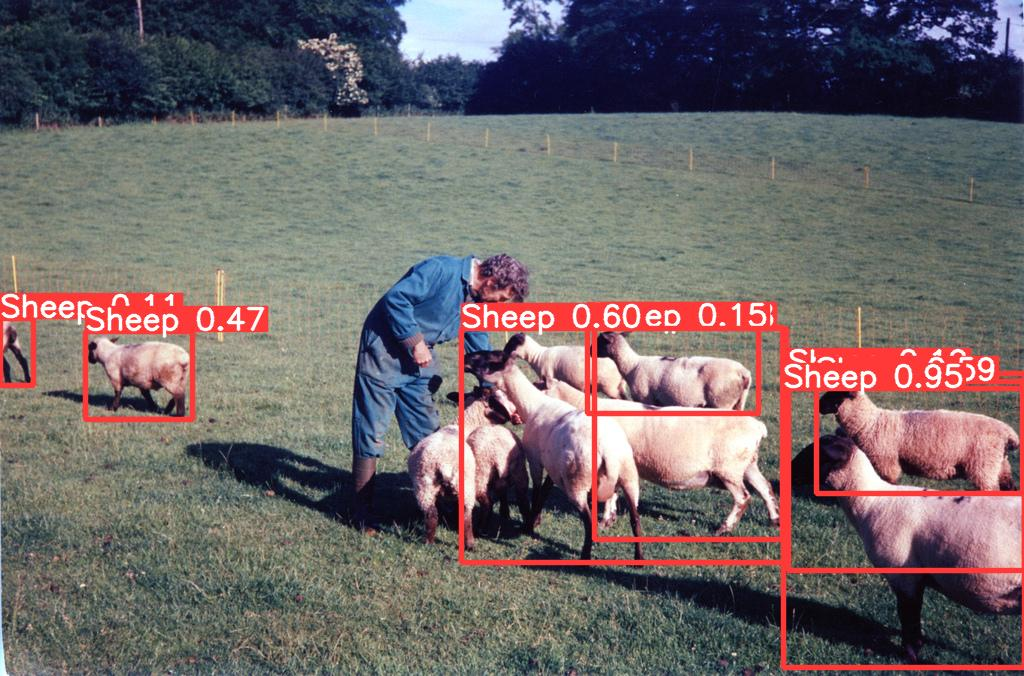

In [16]:
results_path = 'C:/Users/Ivona/Desktop/Codeasy/results.jpg'
display(Image(filename=results_path, width=600, height=300))

### Vizualizacija točnosti tijekom treniranja

Folderi s neuspješnim treniranjima (primjerice zbog "Python Kernel died") nisu sadržavali nikakve datoteke pa su naknadno izbrisani iz direktorija detect. U nastavku su spojeni .csv fileovi s rezultatima treniranja i rezultati su vizualizirani.

In [2]:
t = ['train3', 'train7', 'train8', 'train9', 'train17', 'train20']
p = 'C:/Users/Ivona/Desktop/Codeasy/runs/detect/'
dfs = []
for tr in t:
    putanja = p + str(tr) + '/results.csv'
    df = pd.read_csv(putanja)
    dfs.append(df)
merged_df = pd.concat(dfs, ignore_index=True)

In [12]:
precision_metrics = ['   metrics/precision(B)', '       metrics/mAP50(B)', '    metrics/mAP50-95(B)']
loss_functions = ['           val/box_loss', '           val/cls_loss', '           val/dfl_loss']

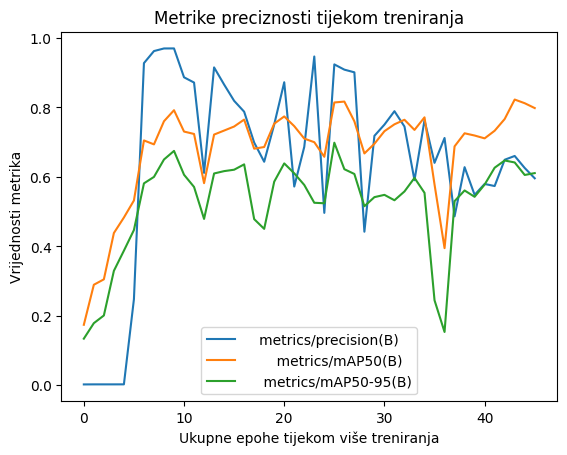

In [13]:
for pm in precision_metrics:
    plt.plot(merged_df[pm], label=pm)
plt.legend()
plt.title('Metrike preciznosti tijekom treniranja')
plt.xlabel('Ukupne epohe tijekom više treniranja')
plt.ylabel('Vrijednosti metrika')
plt.show()

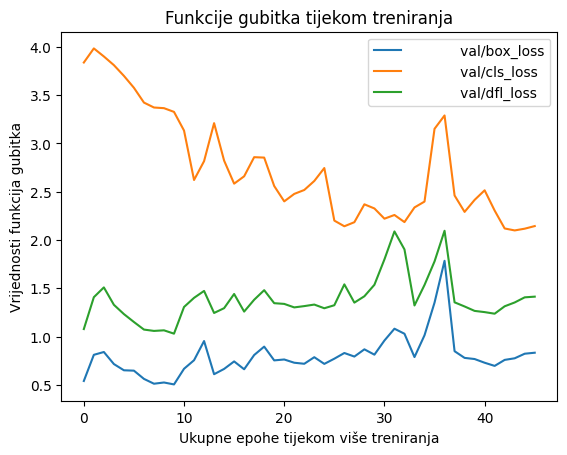

In [14]:
for lf in loss_functions:
    plt.plot(merged_df[lf], label=lf)
plt.legend()
plt.title('Funkcije gubitka tijekom treniranja')
plt.xlabel('Ukupne epohe tijekom više treniranja')
plt.ylabel('Vrijednosti funkcija gubitka')
plt.show()

S obzirom na rezultate validacije, ponašanje metrika te detekciju na skupu za testiranje, model iz train20 pokazuje najbolje performanse. Dotrenirani model ima ukupnu preciznost mAP50 od 82%, odnosno 77% pri prepoznavanju ovaca i 78% pri prepoznavanju sova. Metrika mAP50-95 ima ukupnu vrijednost od oko 64% na skupu za validaciju, odnosno 56% za slike ovaca i 72% za slike sova.
Box P (preciznost detektiranih bounding boxes) je 66% ukupno, odnosno 61% za slike ovaca i 70% za slike sova. Recall, koji predstavlja sposobnost modela da detektira sve instance neke klase, iznosi 85% ukupno, za slike ovaca 91%, a za slike sova 78%.

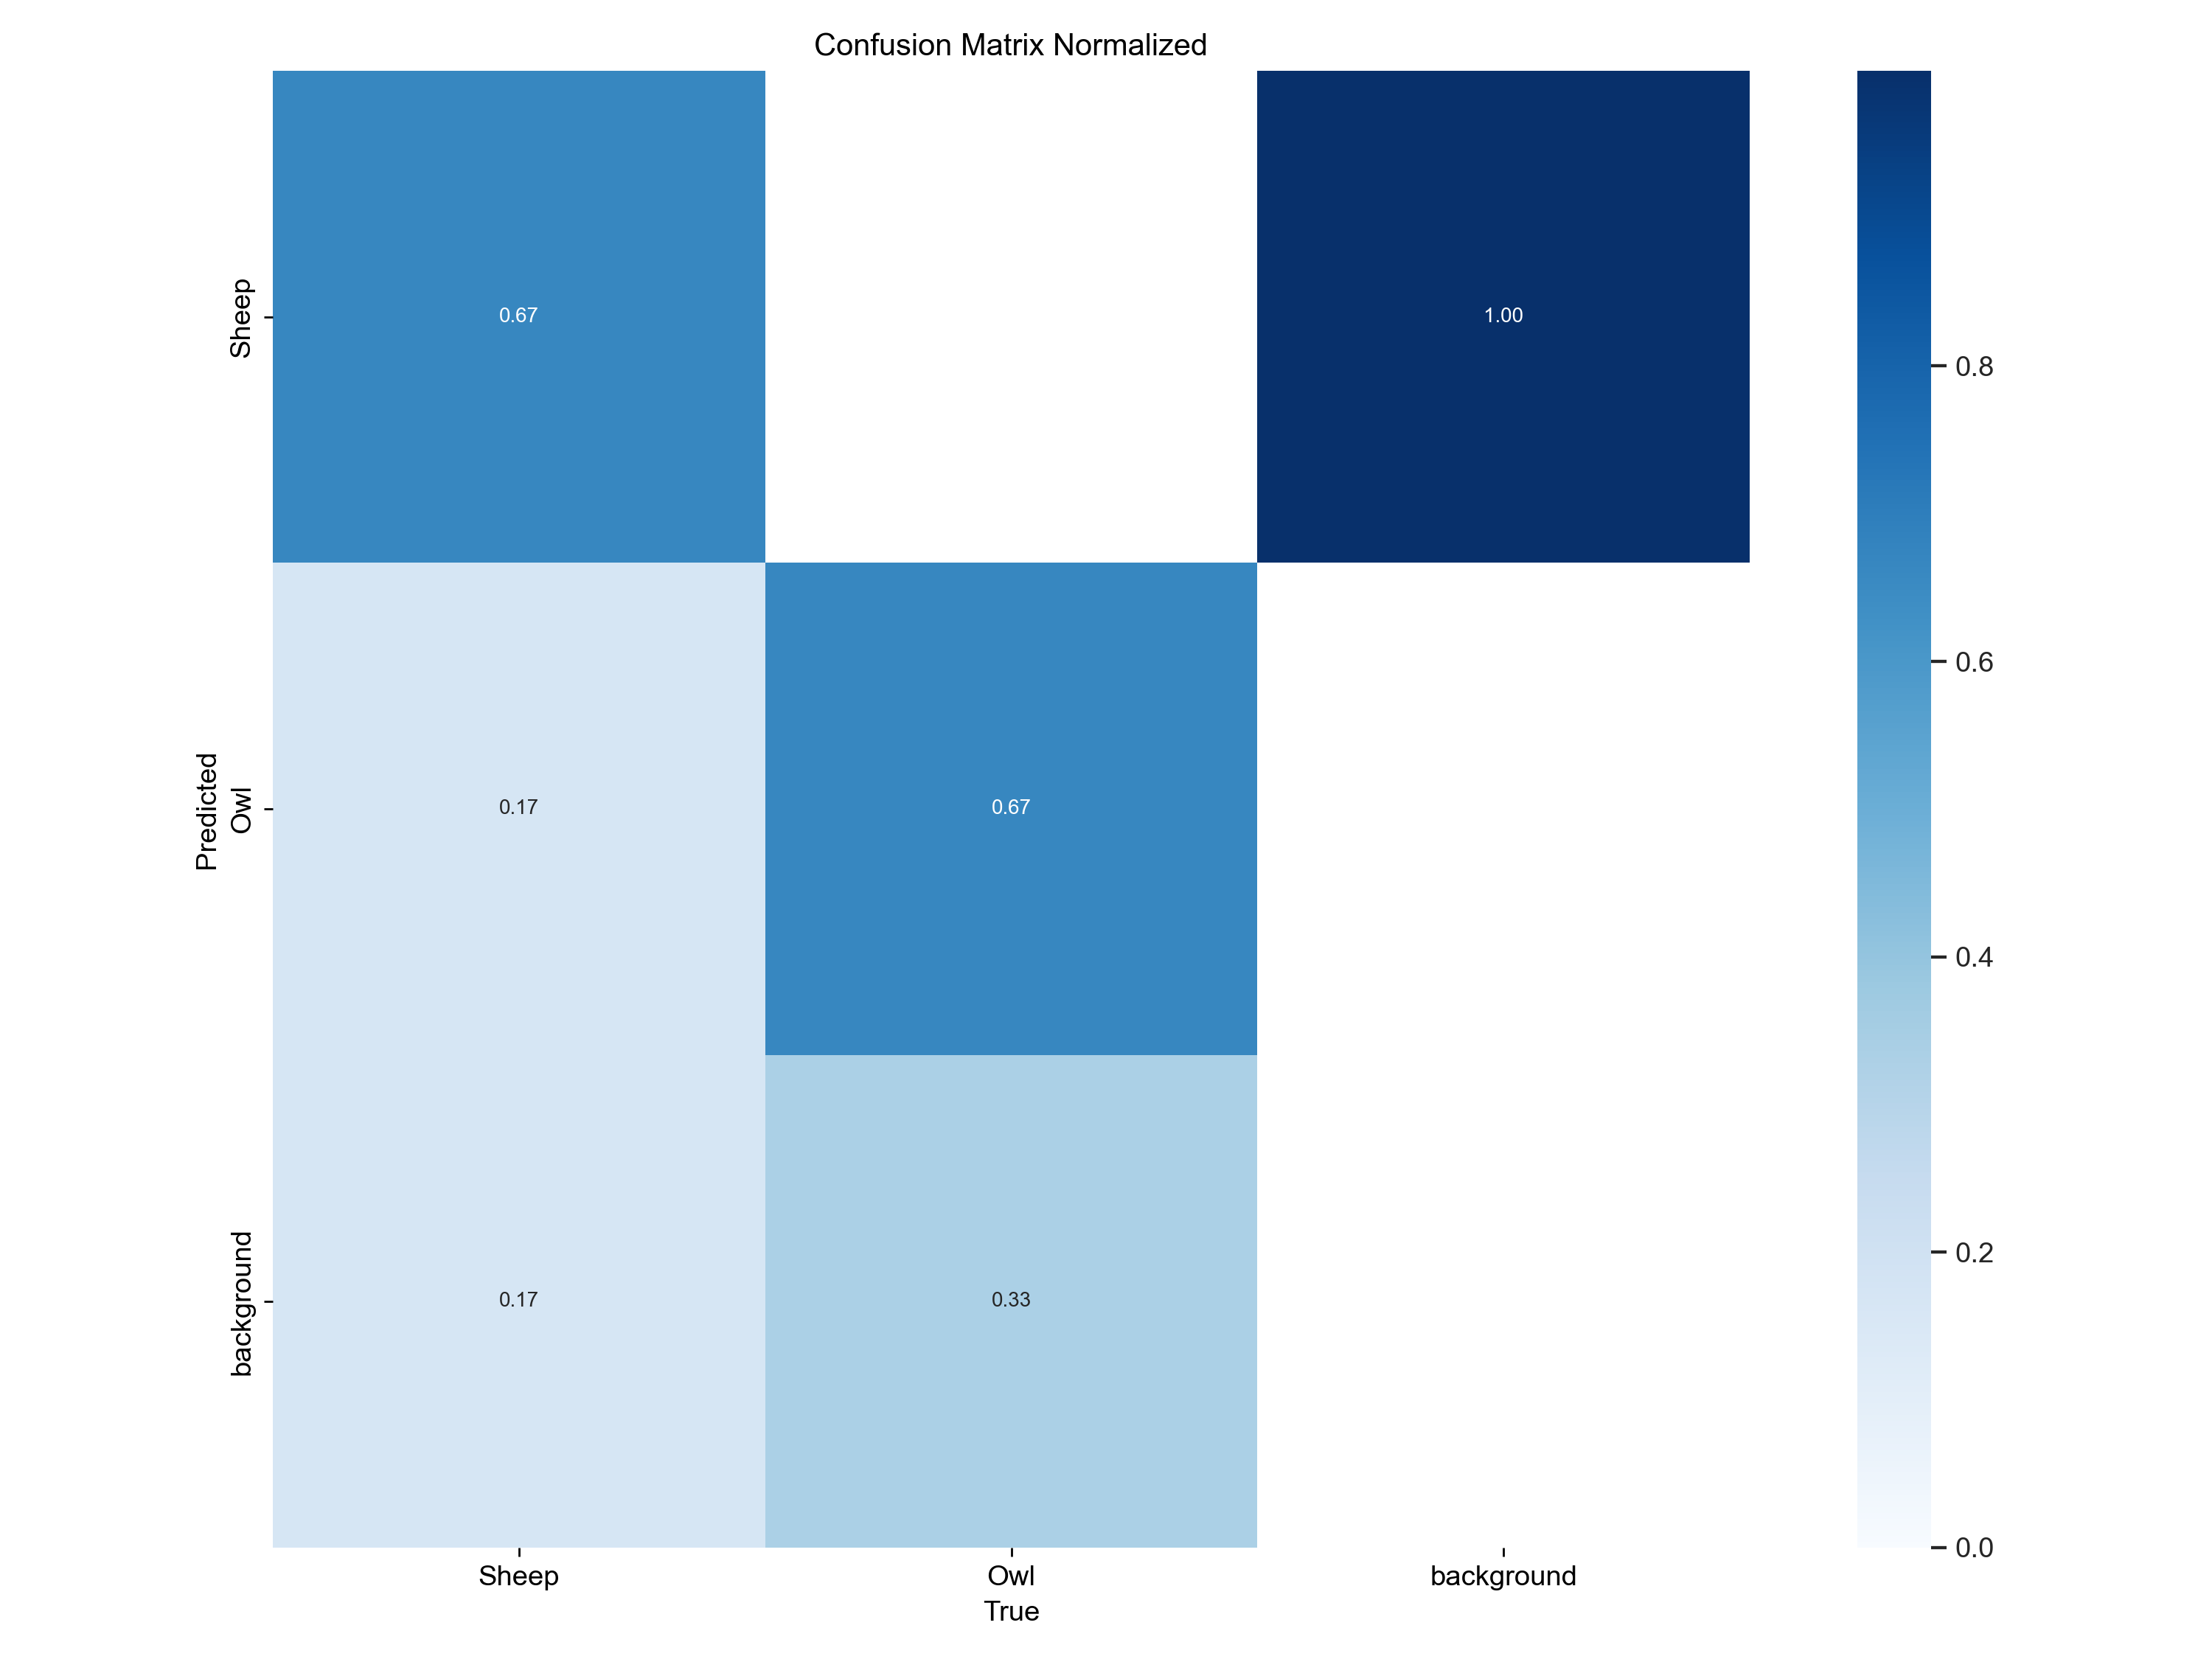

In [55]:
matrix_path = 'C:/Users/Ivona/Desktop/Codeasy/runs/detect/train20/confusion_matrix_normalized.png'
display(Image(filename=matrix_path, width=800, height=800))

Iz matrice konfuzije dobivenoj pri treniranju uočavamo da je za klase Sheep i Owl matrica gotovo dijagonalna, uz mala odstupanja. Model griješi u razlikovanju pozadine i detektira je kao klasu Sheep.

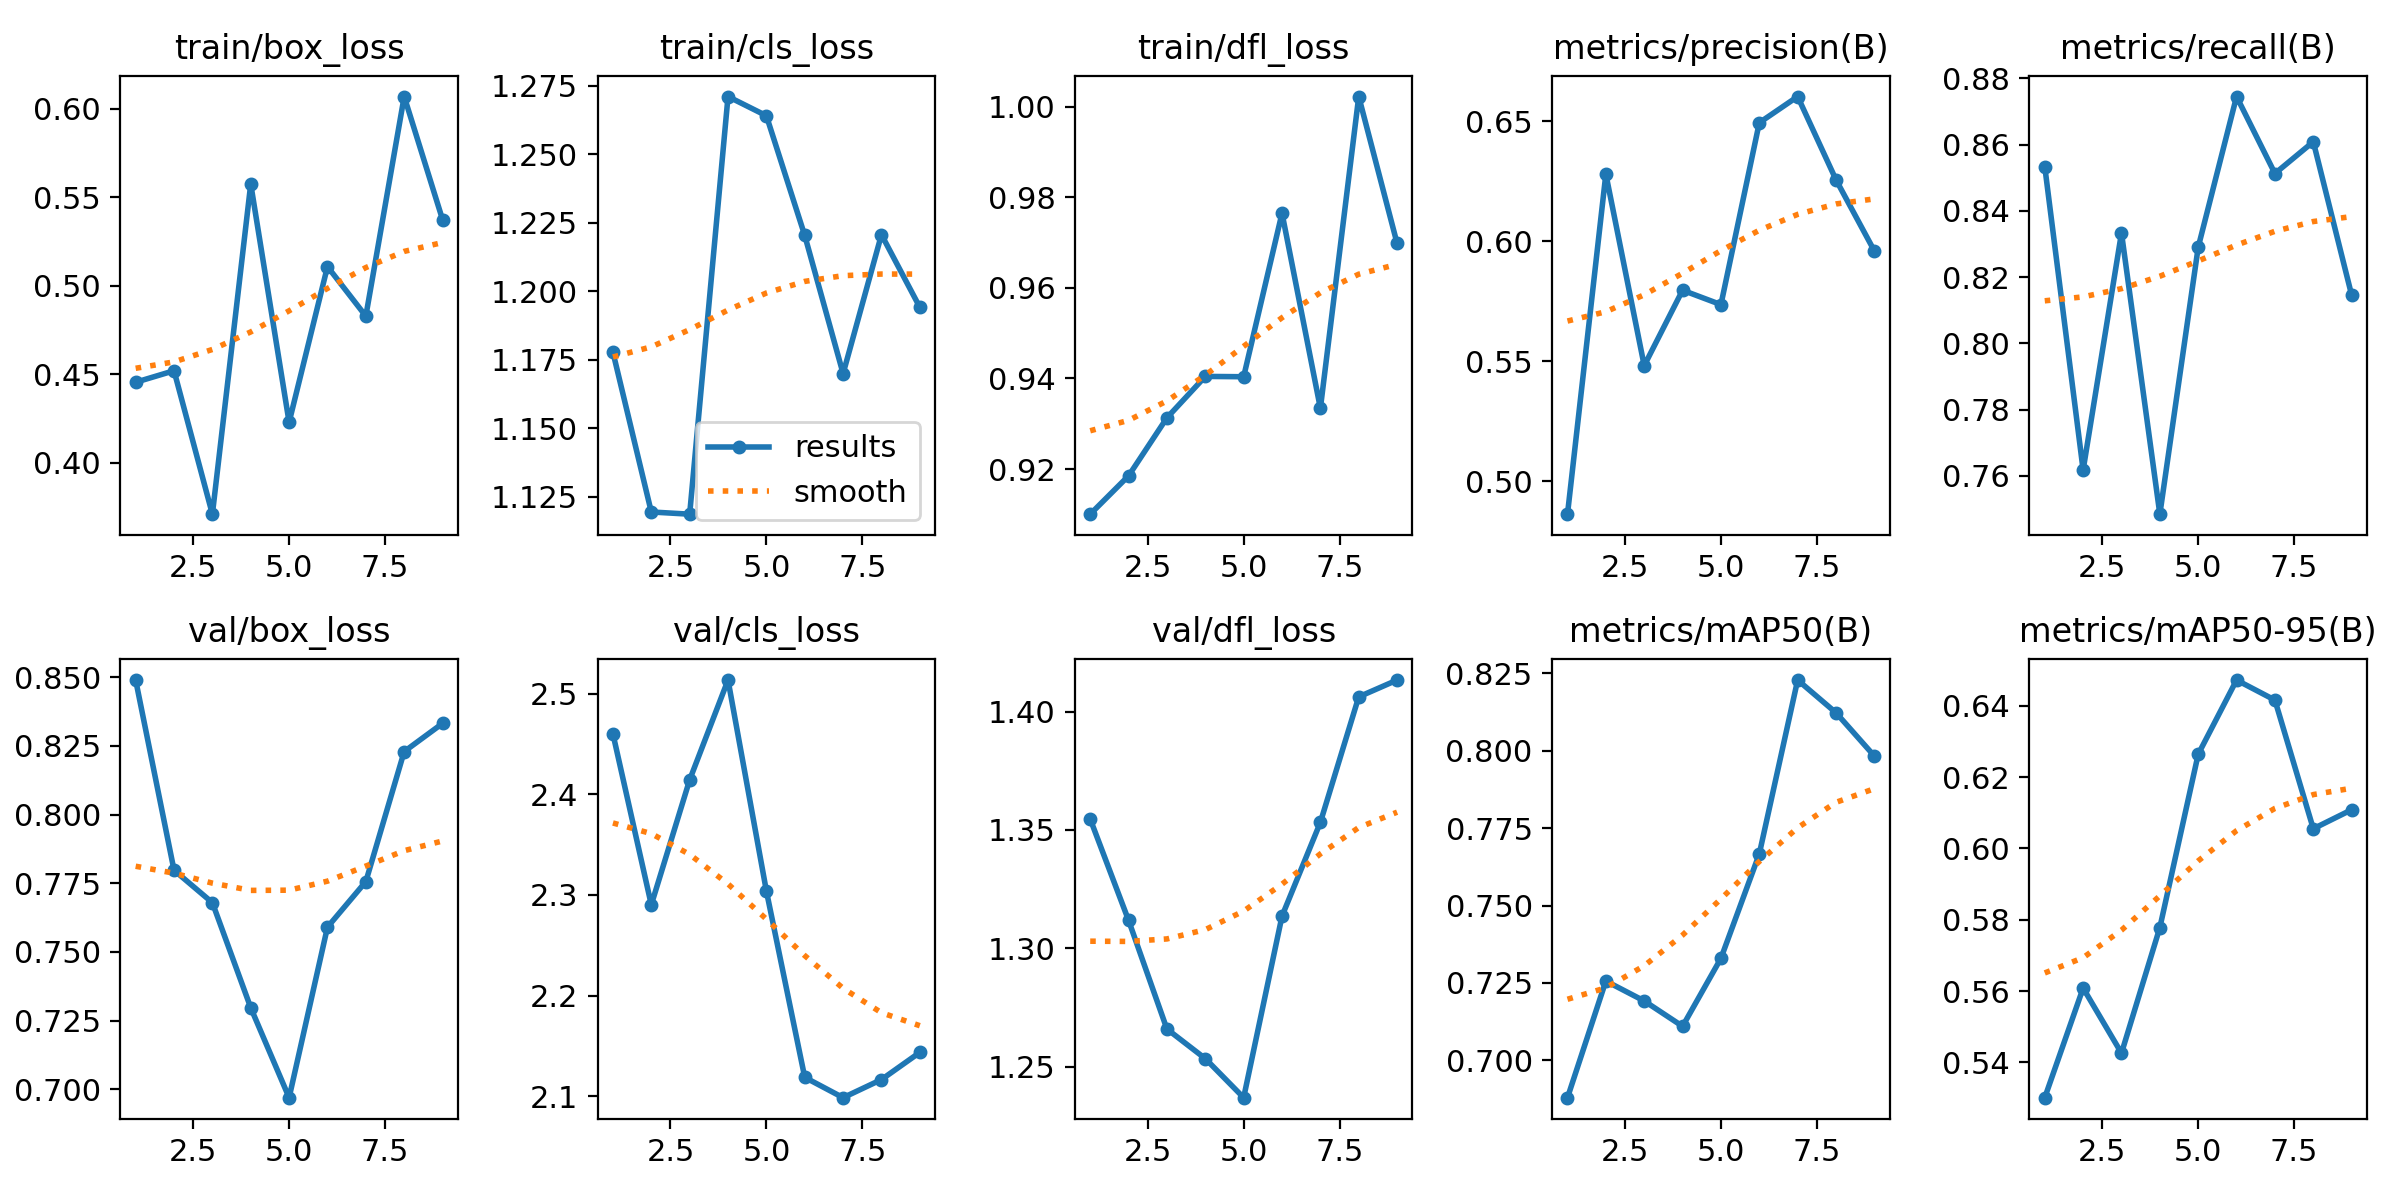

In [18]:
image_path = 'C:/Users/Ivona/Desktop/Codeasy/runs/detect/train20/results.png'
display(Image(filename=image_path, width=800))

S obzirom na opisani pad funkcije gubitka na validacijskom skupu te porast metrika preciznosti, a uzimajući u obzir veličinu preuzetog dataseta, ovaj model postiže solidne rezultate u detekciji sova i ovaca.